In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist

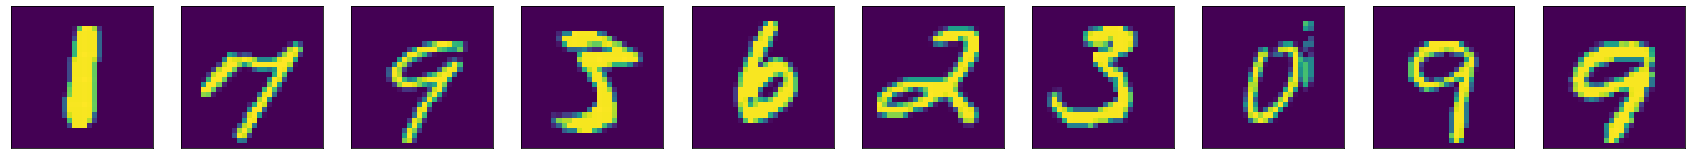

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to [0., 1.]
x_train = x_train / 255
x_test = x_test / 255

# Take a look at the dataset
n = 10
idx = random.sample(range(x_train.shape[0]), n)
plt.figure(figsize=(30,4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(x_train[idx[i]].squeeze());
    plt.xticks([], [])
    plt.yticks([], [])

- 2D Visulization of data using Autoencoder

In [3]:
# This is the dimension of the latent space (encoding space)
latent_dim = 2

# Images are 28 by 28
img_shape = (x_train.shape[1], x_train.shape[2])

encoder = Sequential([
    tf.keras.layers.Flatten(input_shape=img_shape),
    Dense(192, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(latent_dim, name='encoder_output')
])

decoder = Sequential([
    Dense(64, activation='relu', input_shape=(latent_dim,)),
    Dense(128, activation='relu'),
    Dense(img_shape[0] * img_shape[1], activation='relu'),
    tf.keras.layers.Reshape(img_shape)
])

In [4]:
class TestEncoder(tf.keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        super(TestEncoder, self).__init__()
        self.x_test = x_test
        self.y_test = y_test
        self.current_epoch = 0

    def on_epoch_begin(self, epoch, logs={}):
        self.current_epoch = self.current_epoch + 1
        encoder_model = Model(inputs=self.model.input, outputs=self.model.get_layer('encoder_output').output)
        encoder_output = encoder_model(self.x_test)
        plt.subplot(4, 3, self.current_epoch)
        plt.scatter(encoder_output[:, 0],
                    encoder_output[:, 1], s=20, alpha=0.8,
                    cmap='Set1', c=self.y_test[0:x_test.shape[0]])
        plt.xlim(-9, 9)
        plt.ylim(-9, 9)
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

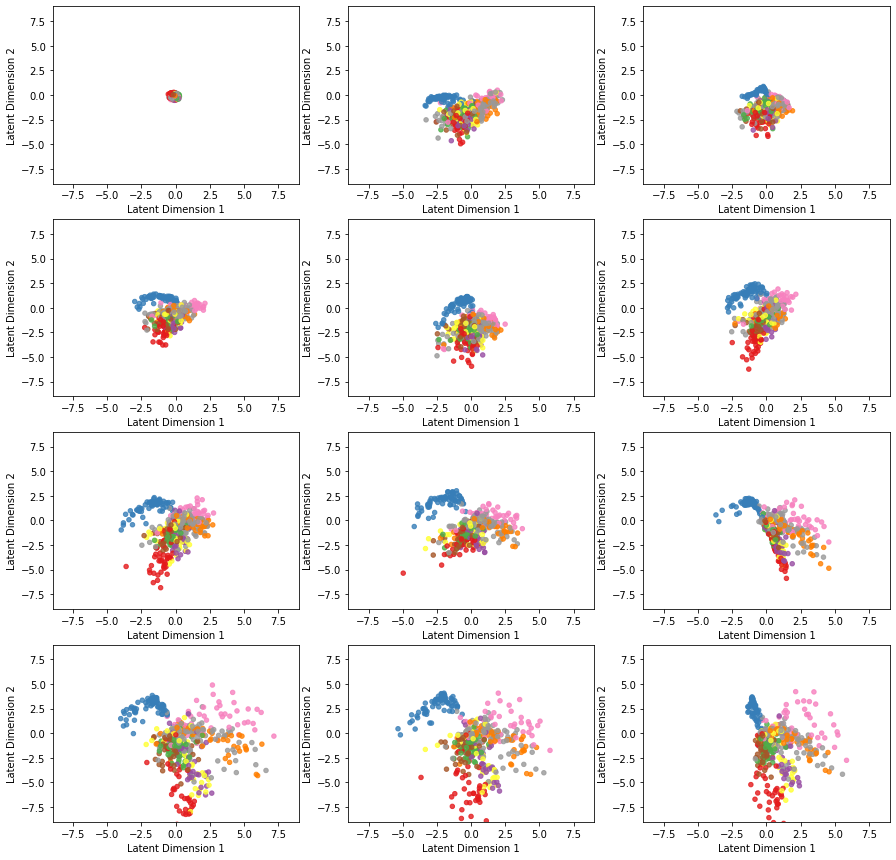

In [5]:
plt.figure(figsize=(15,15))
model_history = autoencoder.fit(x_train, x_train, epochs=12, batch_size=32, verbose=0,
                                callbacks=[TestEncoder(x_test[0:500], y_test[0:500])])


Here is the evolution of latent space representation as the autoencoder is trained, starting with an untrained state at the top left and ending in a fully trained state at the bottom right. Before the first epoch, all the original space data are projected on the same point of the latent space. However, as the autoencoder undergoes training, the points corresponding to different classes start to separate.

In [6]:
print(model_history.history.keys())

dict_keys(['loss'])


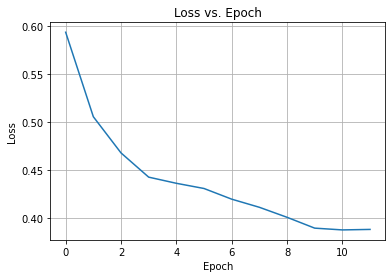

In [7]:
plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

- 2D Visulization of data using PCA

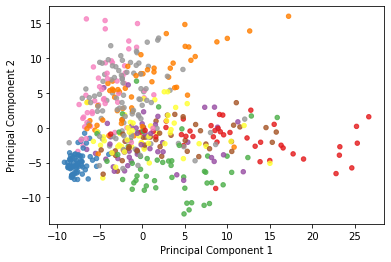

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_reshaped = x_test[0:500].reshape(-1, 784)              # new shape is (500, 28*28) = (500, 784)
x_scaled = StandardScaler().fit_transform(x_reshaped)    # center and scale data (mean=0, std=1)
x_transformed = pca.fit(x_scaled).transform(x_scaled)

plt.figure()
plt.scatter(x_transformed[:, 0], x_transformed[:, 1], s=20, alpha=.8, cmap='Set1', c=y_test[0:500])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

- 2D Visulization of data using t-Distributed Stochastic Neighbor Embedding

C:\Users\Pradip\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Pradip\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


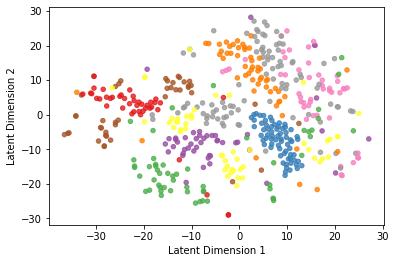

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
x_reshaped = x_test[0:500].reshape(-1, 784)              # new shape is (500, 28*28) = (500, 784)
x_scaled = StandardScaler().fit_transform(x_reshaped)    # center and scale data (mean=0, std=1)
x_transformed = tsne.fit_transform(x_scaled)
labels = y_test[0:500]

plt.figure()
plt.scatter(x_transformed[:, 0], x_transformed[:, 1], s=20, alpha=.8, cmap='Set1', c=y_test[0:500])
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2');